# Extract e-features from voltage clamp current responses

Created by Darshan Mandge and Aurelien Jaquier, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

This notebook explains how to use traces from voltage clamp in eFEL. First, you need to load your modules and your trace data. Here, we will use experimental data from Channelpedia: https://channelpedia.epfl.ch/expdata/details/9430

    Ranjan R, Logette E, Marani M, Herzog M, Tache V, Scantamburlo E, Buchillier V and Markram H (2019) A Kinetic Map of the Homomeric Voltage-Gated Potassium Channel (Kv) Family. Front. Cell. Neurosci. 13:358. https://doi.org/10.3389/fncel.2019.00358

    Blue Brain Project Portal (https://portal.bluebrain.epfl.ch) and Channelpedia (https://channelpedia.epfl.ch)

Curerently, it is present in [here](https://openbraininstitute.sharepoint.com/:u:/s/OBI-Scientificstaff/EWpiWrth3gJMu1uVox1OrRMB0DByhMOzqKeeShvS01A7AA?e=O6qt9k) in OneDrive location: ``OBI -> Scientific staff -> Documents -> Data -> Analysis notebook data -> ephys`

Download the folder with the file and put it here `./Cellular/efeature_extraction`

In [1]:
import h5py
import numpy as np

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import efel

The NWB data file contains experimental data from patch clamp experiments as described in [Ranjan et al. 2019](https://doi.org/10.3389/fncel.2019.00358). 

The experiments were performed on cells from cell lines such as Chinese hamster ovary (CHO). The CHO cells do not have their own native channel expressed.
Individual ion channel genes cloned from rat/mouse are expressed in these cells and automated patch clamp recordings are performed on these cells. 

The data [above](https://channelpedia.epfl.ch/expdata/details/9430) is from Cell line: CHO FT rKv1.1. The gene expressed is for Kv1.1 ion channel cloned from rat cells. The recordings were made at 25 degree celsius.

The patched cells were held at different voltage clamp levels and the intracellular currents were recorded for activation, inactivation and deactivation properties of the ion channels.

The goal of this notebook is to extract features for these properties which are then useful to construct ion channels.

## Activation traces

We will start to load the data form the nwb file. In this notebook, we will use the traces from three experiments: Activation, Deactivation and Inactivation.

In [2]:
data_path = "../ephys/rCell9430.nwb" # Path to the voltage clamp NWB file. The data can come from either channelpedia or copied data on AWS. 
                            # These types of files are currently not registered on OBP

data = {}
exp_types = ["Activation", "Deactivation", "Inactivation"]
with h5py.File(data_path, "r") as content:
    for exp_type in exp_types:
        data[exp_type] = {}
        reps = content["acquisition"]["timeseries"][exp_type]["repetitions"]
        for rep_name, rep in reps.items():
            data[exp_type][rep_name] = {
                "dt": np.asarray(rep["x_interval"], dtype=np.float32),
                "current": np.asarray(rep["data"], dtype=np.float32),
            }

Now we will turn this data into the traces list expected by eFEL. Here, we will start with the traces from the activation experiment.

For this example, we will only use the 1st repetition. You can change the repetition by renaming the rep_name variable into 'repetition2' or 'repetition3'. Notice that we have to give the time in ms. 

**Attention!** eFEL was designed mainly to extract features from voltage timeseries. The voltage clamp data are currents. To use the eFEL features with voltage clamp data, we have to give the current recording to the "V" key in the trace dict. eFEL will treat the current trace as if it were a voltage trace.

As eFEL requires stim_start and stim_end to extract the features, we need to find the these from from experimental data. Let's plot the data and find their values.

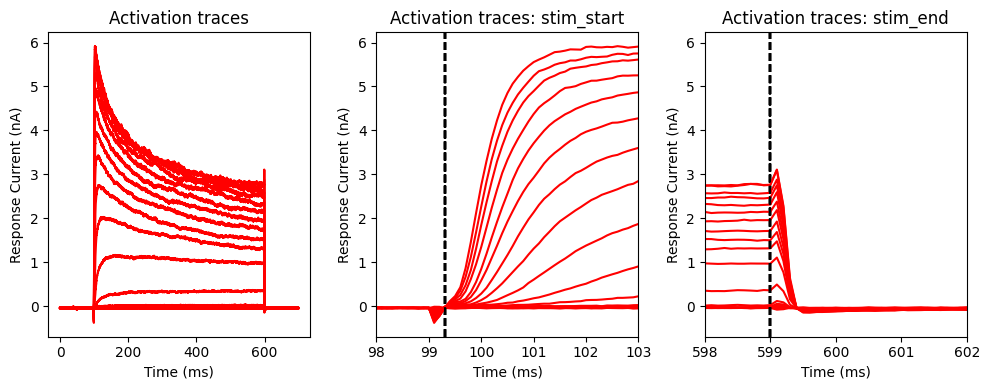

In [3]:
rep_name = "repetition1"
exp_type = "Activation"

# create a subplot with 3 columns to show the start and end time of the activation trace
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for idx in range(len(data[exp_type][rep_name]["dt"])):
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx] * 1000.0 # data was is in seconds, convert to ms

    axs[0].plot(t, i, c="red")
    axs[0].set_xlabel("Time (ms)")
    axs[0].set_ylabel("Response Current (nA)")
    axs[0].set_title("Activation traces")                 

    axs[1].plot(t, i, c="red")
    axs[1].set_xlabel("Time (ms)")
    # add a vertical dashed line at x=99
    axs[1].axvline(x=99.3, color='black', linestyle='--')
    axs[1].set_xlim(98, 103)
    axs[1].set_ylabel("Response Current (nA)")
    axs[1].set_title("Activation traces: stim_start")

    axs[2].plot(t, i, c="red")
    axs[2].set_xlabel("Time (ms)")
    axs[2].set_xlim(598, 602)
    axs[2].axvline(x=599, color='black', linestyle='--')
    axs[2].set_ylabel("Response Current (nA)")
    axs[2].set_title("Activation traces: stim_end")

plt.tight_layout()
plt.show()

From the above, we can see that the stimulus starts at 99.3 ms and end at 599 ms. Now, let's construct a list `traces` of the `trace` dictionaries 

In [4]:
traces = []
rep_name = "repetition1"
exp_type = "Activation"
for idx in range(len(data[exp_type][rep_name]["dt"])):
    trace = {}
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx]
    # efel expects ms: s -> ms
    t = t * 1000.0
    trace["T"] = t
    trace["V"] = i  # trick: input current as if it was voltage
    trace["stim_start"] = [99.3]
    trace["stim_end"] = [599]
    traces.append(trace)

We can now extract the desired features from eFEL. Even if there is 'voltage' in the feature names, since we gave the current trace instead of the voltage trace, it will still compute these features for the current trace. 

So here, 

- `maximum_voltage` will actually compute the maximum of the current, 
- `voltage_base` will compute the current base and 
- `steady_state_voltage_stimend` will compute the current steady state at the end of the stimulus. 

While those three features are usually used on voltage traces, the last one `activation_time_constant` has been written specifically for this kind of voltage clamp activation trace.

In [5]:
feature_names = ["maximum_voltage", "voltage_base", "steady_state_voltage_stimend", "activation_time_constant"]
feats = efel.get_feature_values(traces, feature_names)

From these features, we can get several information. 

We can, for example, extract the 'activation voltage', defined in [Ranjan et al. 2019](https://doi.org/10.3389/fncel.2019.00358) ([Figure 2](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2)) caption, as the voltage clamp level at which the maximum current of the trace is at least 10% of the maximum current among all of the traces.

The stimuli i.e. voltage clamp levels come from electrophysiiology data and can be found in the channelpedia [data page](https://channelpedia.epfl.ch/expdata/details/9430). 

The data is absent in the nwb data file used for this example. If you use a different data file, please look within `content["stimulus"]["presentation"][exp_type]["data"]` where `content` is the data dictionary as created above. Modify, the voltage levels for `stim_v` list used in this notebook.

See plot with title `Activation #3` under **Activation** to find the stimuls voltage levels used in the experiments. The base voltage level is -80 mV and voltage is clamped between -90 to 90 mV intervals of 10 mV. We will use these voltage levels in the list `stim_v`.


In [6]:
# Stimulus Voltage used in the experiment - used later for plotting
stim_v = list(range(-90, 90, 10))

max_i = np.array([feat_dict["maximum_voltage"][0] for feat_dict in feats])
max_i = max_i / np.max(max_i)

act_v_idx = np.argwhere(max_i >= 0.1)[0][0]
act_v = stim_v[act_v_idx]
act_i = max_i[act_v_idx]
ylim = [np.min(max_i) - 0.05, 1.05]
print(f"Activation voltage is at {act_v} mV")

Activation voltage is at -20 mV


Here, we plot the I-V curve for the 1st repetition, and we mark the activation voltage with a red line

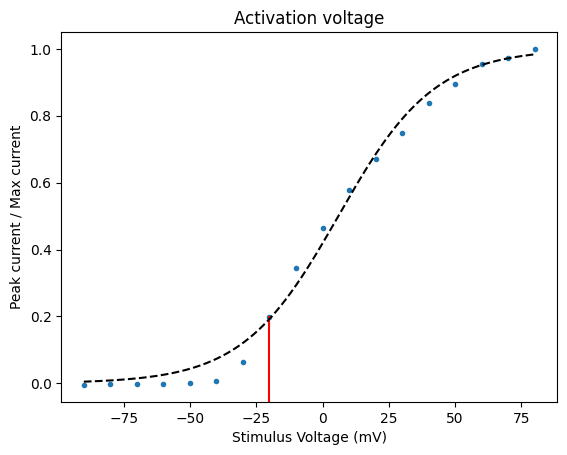

In [7]:
plt.plot(stim_v, max_i, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Peak current / Max current")
plt.plot([act_v, act_v], [ylim[0], act_i], color="red")
plt.ylim(ylim)
plt.title("Activation voltage")

# sigmoid fit
def sigmoid(v, delta, tau):
    return 1 / (1 + np.exp(-(v - delta) / tau))

popt, _ = curve_fit(sigmoid, stim_v, max_i)
v = np.linspace(stim_v[0], stim_v[-1], 200)
i = sigmoid(v, *popt)
plt.plot(v, i, "--", c="black")

You can also compare this plot for similarity with the `I-V` plot in [Figure 2A](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2) of Ranjan et al. 2019. 

We can also show the evolution of the absolute steady state current at the end of the stimulus across input voltage. Note, the sigmoidal curve below is not normalised with respect to the peak and the plot steady state value go above 1.

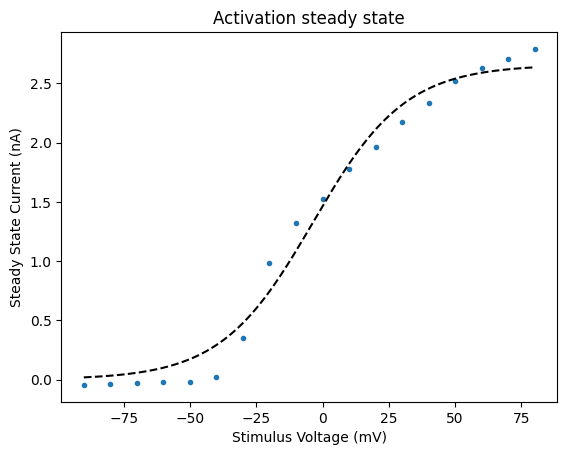

In [8]:
ssis = np.array([feat_dict["steady_state_voltage_stimend"][0] for feat_dict in feats])
plt.plot(stim_v, ssis, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Steady State Current (nA)")
plt.title("Activation steady state")

# sigmoid fit
def sigmoid_scaled(v, delta, tau, A):
    return A / (1 + np.exp(-(v - delta) / tau))

popt, _ = curve_fit(sigmoid_scaled, stim_v, ssis)
ss = sigmoid_scaled(v, *popt)
plt.plot(v, ss, "--", c="black")

We can also plot the current base. Since this feature is computed on the trace before the stimulus is applied, it should be constant across the traces.

Text(0.5, 1.0, 'Activation current base')

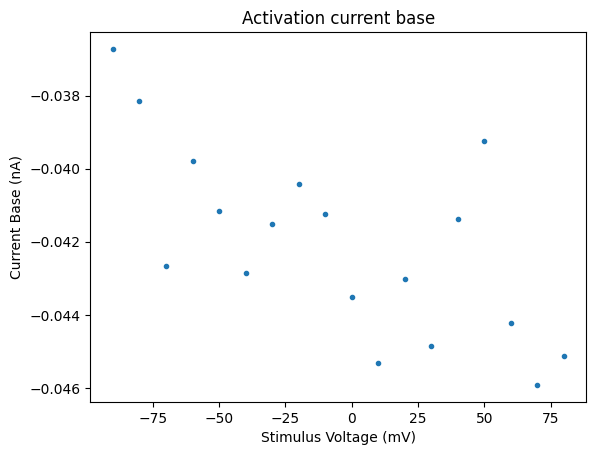

In [9]:
i_base = np.array([feat_dict["voltage_base"][0] for feat_dict in feats])
plt.plot(stim_v, i_base, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Current Base (nA)")
plt.title("Activation current base")

We can see that the current base is the similar for all stimulus voltages, which is expected since it is computed before the stimulus is applied.

Finally, we can get the time constant of the activation curve (from `stim_start` to the maximum of the trace):

Text(0.5, 1.0, 'Activation time constant')

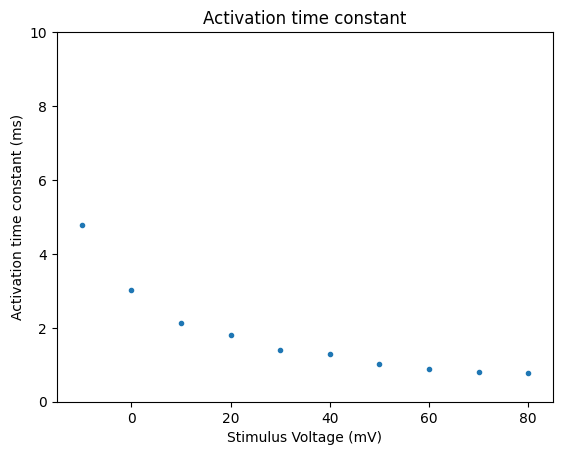

In [10]:
act_tau_efel = np.array([feat_dict["activation_time_constant"][0] for feat_dict in feats])
plt.plot(stim_v, act_tau_efel, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Activation time constant (ms)")
plt.xlim((-15, 85))
plt.ylim((0, 10))
plt.title("Activation time constant")

As a visual verification, we can do an exponential fit to the traces, use our time constant as a parameter of the exponential and plot the exponential on top of the trace. You can also compare this plot for $Act_{\tau}$ in [Figure 2A](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2) of Ranjan et al. 2019. 

(90.0, 170.0)

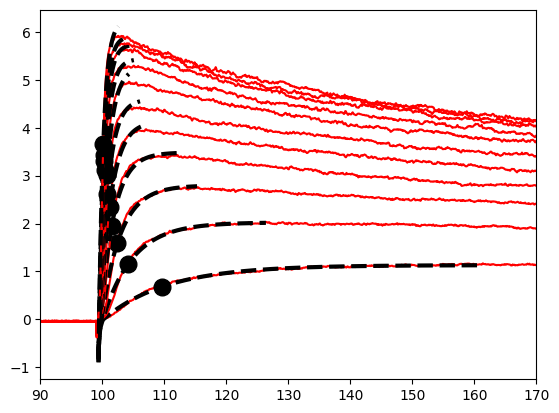

In [11]:
def exp_fit(t, tau_1, A1, A0):
        return A0 - A1 * np.exp(-t / tau_1)

for i, trace in enumerate(traces):
        stim_start_idx = np.argwhere(trace["T"] >= trace["stim_start"][0])[0][0]
        stim_end_idx = np.argwhere(trace["V"] >= np.max(trace["V"]))[0][0]
        # trace["stim_end"] - 1 to account for artefact
        if stim_end_idx < stim_start_idx or trace["T"][stim_end_idx] > trace["stim_end"][0] - 1:
                continue
        t_interval = trace["T"][stim_start_idx:stim_end_idx + 1]
        v_interval = trace["V"][stim_start_idx:stim_end_idx + 1]
        t0 = t_interval[0]
        t_interval_corrected = t_interval - t0
        
        popt, _ = curve_fit(exp_fit, t_interval_corrected, v_interval)

        v_fit = exp_fit(t_interval_corrected, act_tau_efel[i], popt[1], popt[2])
        plt.plot(trace["T"], trace["V"], c="red")
        plt.plot(t_interval, v_fit, "--", c="black", lw=3)
        t_tau = popt[0] + t0
        plt.plot(t_tau, exp_fit(popt[0], *popt), 'o', color='black', markersize=12)
plt.xlim(90, 170)

## Deactivation traces

Now we will also perform efeature extraction on traces from deactivation experiment. First, we load the data from the file. Once again, first plot the traces to get the `stim_start` and `stim_end`.

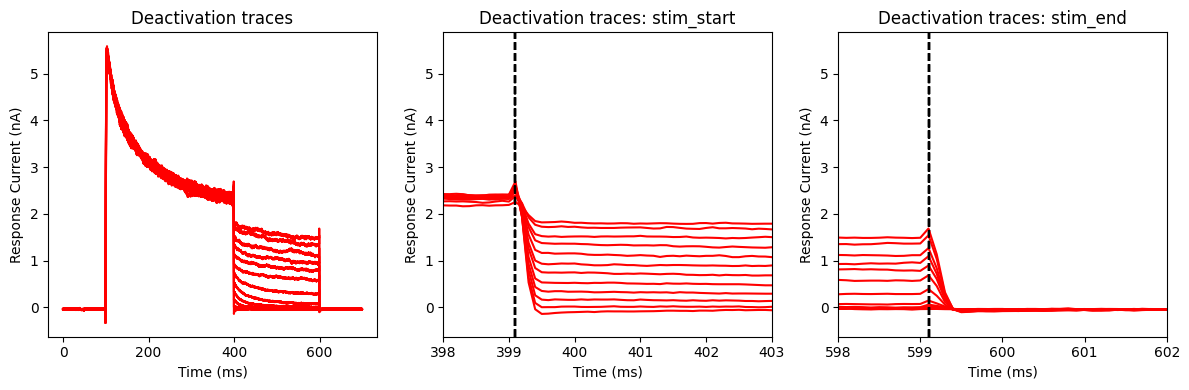

In [12]:
rep_name = "repetition1"
exp_type = "Deactivation"

# create a subplot with 2  columns to show the start and end time of the Deactivation trace
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for idx in range(len(data[exp_type][rep_name]["dt"])):
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx] * 1000.0 # data was is in seconds, convert to ms

    axs[0].plot(t, i, c="red")
    axs[0].set_xlabel("Time (ms)")
    axs[0].set_ylabel("Response Current (nA)")
    axs[0].set_title("Deactivation traces")

    axs[1].plot(t, i, c="red")
    axs[1].set_xlabel("Time (ms)")
    # add a vertical dashed line at x=99
    axs[1].axvline(x=399.1, color='black', linestyle='--')
    axs[1].set_xlim(398, 403)
    axs[1].set_ylabel("Response Current (nA)")
    axs[1].set_title("Deactivation traces: stim_start")

    axs[2].plot(t, i, c="red")
    axs[2].set_xlabel("Time (ms)")
    axs[2].set_xlim(598, 602)
    axs[2].axvline(x=599.1, color='black', linestyle='--')
    axs[2].set_ylabel("Response Current (nA)")
    axs[2].set_title("Deactivation traces: stim_end")

plt.tight_layout()
plt.show()

Notice that here, we are setting the stimulus start at 399.1 and stimulus end at 599 because it represents the interval for channel traes deactivation and will be used for our time constant fit.

We will put the current data under the 'V' key representing the voltage, so that eFEL treats our trace like any voltage trace. 

In [13]:
traces = []
rep_name = "repetition1"
exp_type = "Deactivation"
for idx in range(len(data[exp_type][rep_name]["dt"])):
    trace = {}
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx]
    # efel expects ms: s -> ms
    t = t * 1000.0
    trace["T"] = t
    trace["V"] = i  # trick: input current as if it was voltage
    trace["stim_start"] = [399.1]
    trace["stim_end"] = [599]
    traces.append(trace)

We can now extract the deactivation time constant using eFEL. 

Note the voltage range for deactivation comes from channelpedia data [page](https://channelpedia.epfl.ch/expdata/details/9430). See plot with titled `Deactivation #8` under **Deactivation** to find the stimulus voltage levels used in the experiments. The base voltage level is -80 mV, activation voltage clamp level is 70 mV and voltage for deactivation is clamped between -80 to 40 mV intervals of 10 mV. We will use these voltage levels in the list `stim_v`. 

Text(0.5, 1.0, 'Deactivation time constant')

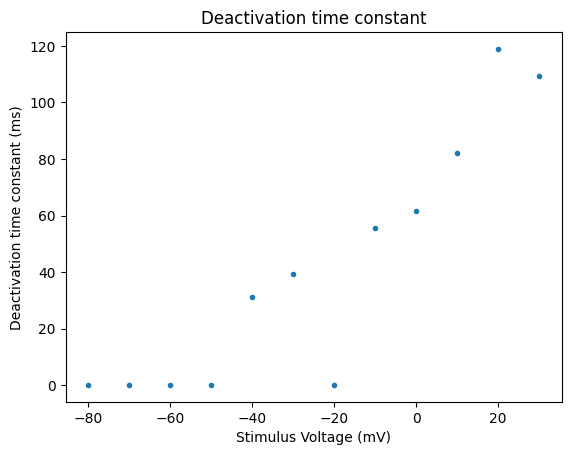

In [14]:
efel.reset()
stim_v = list(range(-80, 40, 10))
feature_names = ["deactivation_time_constant"]
feats = efel.get_feature_values(traces, feature_names)

deact_tau_efel = np.array([feat_dict["deactivation_time_constant"][0] for feat_dict in feats])
plt.plot(stim_v, deact_tau_efel, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Deactivation time constant (ms)")
plt.title("Deactivation time constant")
# plt.xlim((-65, 15))
# plt.ylim((-10, 200))

You can also compare this plot for $Deact_{\tau}$ in [Figure 2B](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2) of Ranjan et al. 2019. 

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_12390/1772092254.py:2: RuntimeWarning: overflow encountered in exp
  return A0 - A1 * np.exp(-t / tau_1)


(390.0, 610.0)

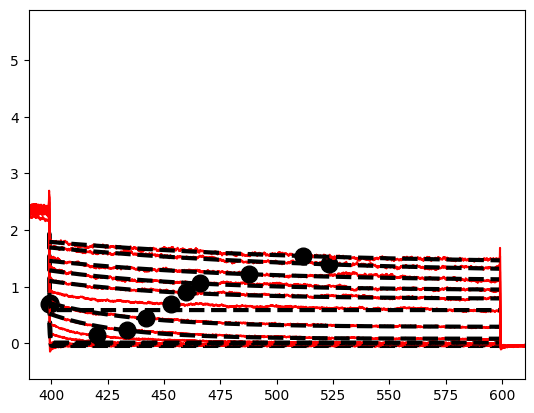

In [15]:
for i, trace in enumerate(traces):
        interval_indices = np.where((trace["T"] >= trace["stim_start"][0]) & (trace["T"] < trace["stim_end"][0]))
        t_interval = trace["T"][interval_indices]
        v_interval = trace["V"][interval_indices]
        t0 = t_interval[0]
        t_interval_corrected = t_interval - t0
        
        popt, _ = curve_fit(exp_fit, t_interval_corrected, v_interval)

        v_fit = exp_fit(t_interval_corrected, deact_tau_efel[i], popt[1], popt[2])
        plt.plot(trace["T"], trace["V"], c="red")
        plt.plot(t_interval, v_fit, "--", c="black", lw=3)
        t_tau = popt[0] + t0
        plt.plot(t_tau, exp_fit(popt[0], *popt), 'o', color='black', markersize=12)
plt.xlim(390, 610)

## Inactivation traces

Now we will also perform efeature extraction on traces from inactivation experiment. 

First, we load the data from the file. Once again, we will put the current data under the 'V' key representing the voltage, so that eFEL treats our trace like any voltage trace. 

For this one, we will have to extract the features in two steps, because they depend on which stimulus interval we are interested in. We will first look into the features we can extract from the stimulus interval between 1600 and 1700 ms.

The below graph shows the inactivation traces.

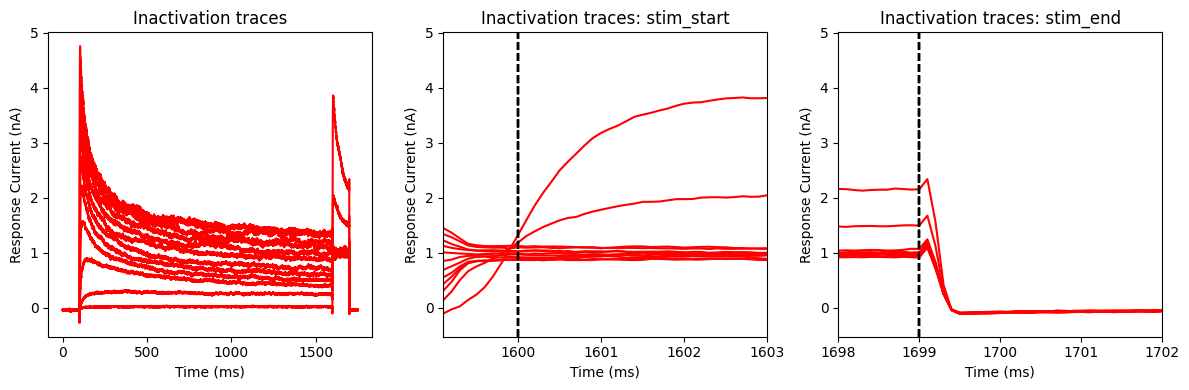

In [16]:
rep_name = "repetition1"
exp_type = "Inactivation"

# create a subplot with 2  columns to show the start and end time of the Inactivation trace
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for idx in range(len(data[exp_type][rep_name]["dt"])):
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx] * 1000.0 # data was is in seconds, convert to ms

    axs[0].plot(t, i, c="red")
    axs[0].set_xlabel("Time (ms)")
    axs[0].set_ylabel("Response Current (nA)")
    axs[0].set_title("Inactivation traces")                 

    axs[1].plot(t, i, c="red")
    axs[1].set_xlabel("Time (ms)")
    # add a vertical dashed line at x=99
    axs[1].axvline(x=1600, color='black', linestyle='--')
    axs[1].set_xlim(1599.1, 1603)
    axs[1].set_ylabel("Response Current (nA)")
    axs[1].set_title("Inactivation traces: stim_start")

    axs[2].plot(t, i, c="red")
    axs[2].set_xlabel("Time (ms)")
    axs[2].set_xlim(1698, 1702)
    axs[2].axvline(x=1699, color='black', linestyle='--')
    axs[2].set_ylabel("Response Current (nA)")
    axs[2].set_title("Inactivation traces: stim_end")

plt.tight_layout()
plt.show()

Let's create the `traces` list dictionaries of inactivation traces for extracting efeatures. 

In [17]:
traces = []
rep_name = "repetition1"
exp_type = "Inactivation"
for idx in range(len(data[exp_type][rep_name]["dt"])):
    trace = {}
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx]
    # efel expects ms: s -> ms
    t = t * 1000.0
    trace["T"] = t
    trace["V"] = i  # trick: input current as if it was voltage
    trace["stim_start"] = [1599.1]
    trace["stim_end"] = [1699]
    traces.append(trace)

We will now plot the I-V curve showing the maximum current in function of the input voltage. Remember that even though we are using the `maximum_voltage` feature, since the trace we have given as input under 'V' is actually current, we will actually get the maximum current by using this feature.

Note the voltage range for deactivation comes from channelpedia data [page](https://channelpedia.epfl.ch/expdata/details/9430). See plot with title `Inactivation #10` under **Inactivation** to find the stimuls voltage levels used in the experiments. The base voltage level is 
-80 mV, voltage clamp vary between is -40 to 80 mV in intervals of 10 mV and inactivation voltage is clamped 30 mV. We will use these voltage levels between -40 to 80 mV in the list `stim_v`. 

(-0.05, 1.05)

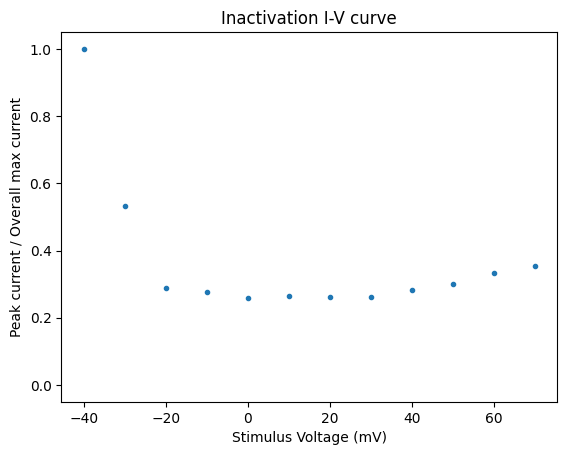

In [18]:
efel.reset()
stim_v = list(range(-40, 80, 10))
feature_names = ["maximum_voltage"]
feats = efel.get_feature_values(traces, feature_names)

max_i = np.array([feat_dict["maximum_voltage"][0] for feat_dict in feats])
max_i = max_i / np.max(max_i)

plt.clf()
plt.plot(stim_v, max_i, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Peak current / Overall max current")
plt.title("Inactivation I-V curve")
plt.ylim((-0.05, 1.05))

You can also compare this plot for `I-V` in [Figure 2C](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2) of Ranjan et al. 2019. The differences with the figure in the paper can because we are using only one recording file of the cell whereas the figure in the paper uses several recordings from different cells leading to variation in the calcualted values as show by the standard deviations in the paper.

We will now compute the inactivation time constant. But in order to do that, we need to change the stimulus start and stimulus end to 100 and 1600 respectively:

In [19]:
traces = []
rep_name = "repetition1"
exp_type = "Inactivation"
for idx in range(len(data[exp_type][rep_name]["dt"])):
    trace = {}
    i = data[exp_type][rep_name]["current"][:,idx]
    t = np.arange(i.size) * data[exp_type][rep_name]["dt"][idx]
    # efel expects ms: s -> ms
    t = t * 1000.0
    trace["T"] = t
    trace["V"] = i  # trick: input current as if it was voltage
    trace["stim_start"] = [99]
    trace["stim_end"] = [1599]
    traces.append(trace)

And now we can compute the inactivation time constant. It will select the trace from the trace maximum up to the end of the stimulus (minus a few data points to avoid artifacts).

Text(0, 0.5, 'Time constant (ms)')

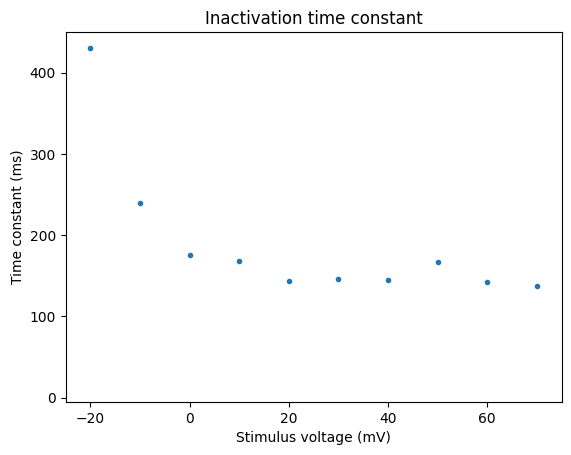

In [20]:
feature_names = ["inactivation_time_constant"]
feats = efel.get_feature_values(traces, feature_names)
inact_tau_efel = np.array([feat_dict["inactivation_time_constant"][0] for feat_dict in feats])
plt.plot(stim_v, inact_tau_efel, '.')
plt.xlim((-25, 75))
plt.ylim((-5, 450))
plt.title("Inactivation time constant")
plt.xlabel("Stimulus voltage (mV)")
plt.ylabel("Time constant (ms)")

Note that if you want to change the number of data points to remove from the end of the trace, you can change it by changing the setting of inactivation_tc_end_skip. Setting it to 0, for example, will keep the artifacts in and can bias the computation, depending on the trace.

Text(0, 0.5, 'Time constant (ms)')

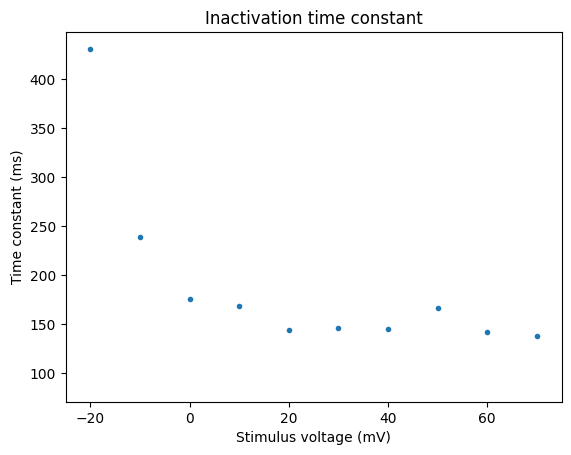

In [21]:
efel.set_setting("inactivation_tc_end_skip", 0)
feature_names = ["inactivation_time_constant", "steady_state_voltage_stimend"]
feats = efel.get_feature_values(traces, feature_names)
inact_tau_efel = np.array([feat_dict["inactivation_time_constant"][0] for feat_dict in feats])
plt.plot(stim_v, inact_tau_efel, '.')
plt.xlim((-25, 75))
plt.title("Inactivation time constant")
plt.xlabel("Stimulus voltage (mV)")
plt.ylabel("Time constant (ms)")

You can also compare this plot for $Inact_\tau$ in [Figure 2C](https://www.frontiersin.org/journals/cellular-neuroscience/articles/10.3389/fncel.2019.00358/full#F2) of Ranjan et al. 2019. 

As a visual verification, we can do an exponential fit to the traces, use our time constant as a parameter of the exponential and plot the exponential on top of the trace.

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_12390/1772092254.py:2: RuntimeWarning: overflow encountered in exp
  return A0 - A1 * np.exp(-t / tau_1)
/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_12390/870918093.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_fit, t_interval_corrected, v_interval)


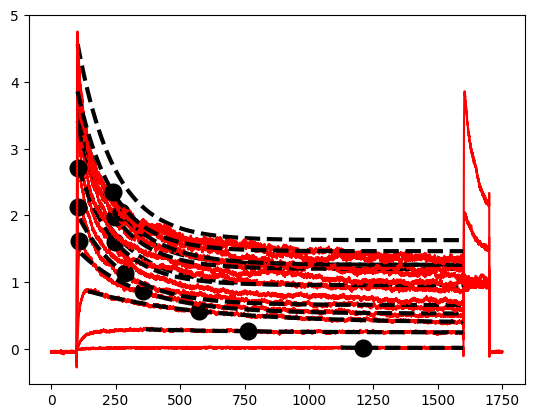

In [22]:
for i, trace in enumerate(traces):
        # - 1 to account for artifacts
        interval_indices = np.where((trace["T"] >= trace["stim_start"][0]) & (trace["T"] < trace["stim_end"][0] - 1))
        t_interval = trace["T"][interval_indices]
        v_interval = trace["V"][interval_indices]
        stim_start_idx = np.argwhere(v_interval >= np.max(v_interval))[0][0]
        t_interval = t_interval[stim_start_idx:]
        v_interval = v_interval[stim_start_idx:]
        t0 = t_interval[0] # for testing
        t_interval_corrected = t_interval - t_interval[0]
        
        popt, _ = curve_fit(exp_fit, t_interval_corrected, v_interval)

        v_fit = exp_fit(t_interval_corrected, inact_tau_efel[i], popt[1], popt[2])
        plt.plot(trace["T"], trace["V"], c="red")
        plt.plot(t_interval, v_fit, "--", c="black", lw=3)
        t_tau = popt[0] + t0
        plt.plot(t_tau, exp_fit(popt[0], *popt), 'o', color='black', markersize=12)
# plt.xlim(390, 610)

Finally, the steady state of the Inactivation curve can be plotted as follow:

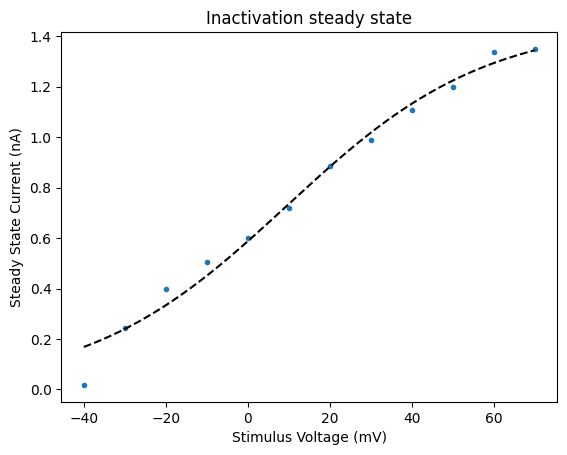

In [23]:
ssis = np.array([feat_dict["steady_state_voltage_stimend"][0] for feat_dict in feats])
plt.plot(stim_v, ssis, '.')
plt.xlabel("Stimulus Voltage (mV)")
plt.ylabel("Steady State Current (nA)")
plt.title("Inactivation steady state")

popt, _ = curve_fit(sigmoid_scaled, stim_v, ssis)
v = np.linspace(stim_v[0], stim_v[-1], 200)
ss = sigmoid_scaled(v, *popt)
plt.plot(v, ss, "--", c="black")